This is a Univariate focusting

It aims at predicting the SALES of PRODUCTLINE using the using LSTM Algorthm and sales_data_sample dataset(dataset is publicly available on Kaggle)

At the end of the project I will have a list of pridicted sales for each product i.e Motorcycles,Classic Cars...

In [1]:
import pandas as pd #linear algebra
import numpy as np #data processing, CSV file
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

salesdata=pd.read_csv("C:\\Users\\ADMIN\\Desktop\\sales_data.csv", encoding= 'latin1')
salesdata.head()


,ORDERNUMBER,QUANTITYORDERED,PRICEEACH,ORDERLINENUMBER,SALES,ORDERDATE,STATUS,QTR_ID,MONTH_ID,YEAR_ID,...,ADDRESSLINE1,ADDRESSLINE2,CITY,STATE,POSTALCODE,COUNTRY,TERRITORY,CONTACTLASTNAME,CONTACTFIRSTNAME,DEALSIZE
0,10107,30,95.70,2,2871.00,2/24/2003 0:00,Shipped,1,2,2003,...,897 Long Airport Avenue,NaN,NYC,NY,10022,USA,NaN,Yu,Kwai,Small
1,10121,34,81.35,5,2765.90,5/7/2003 0:00,Shipped,2,5,2003,...,59 rue de l'Abbaye,NaN,Reims,NaN,51100,France,EMEA,Henriot,Paul,Small
2,10134,41,94.74,2,3884.34,7/1/2003 0:00,Shipped,3,7,2003,...,27 rue du Colonel Pierre Avia,NaN,Paris,NaN,75508,France,EMEA,Da Cunha,Daniel,Medium
3,10145,45,83.26,6,3746.70,8/25/2003 0:00,Shipped,3,8,2003,...,78934 Hillside Dr.,NaN,Pasadena,CA,90003,USA,NaN,Young,Julie,Medium
4,10159,49,100.00,14,5205.27,10/10/2003 0:00,Shipped,4,10,2003,...,7734 Strong St.,NaN,San Francisco,CA,NaN,USA,NaN,Brown,Julie,Medium


Understanding of the LSTM and its flow
Sort the libraries
Predict list

In [2]:
salesdata.columns

Index(['ORDERNUMBER', 'QUANTITYORDERED', 'PRICEEACH', 'ORDERLINENUMBER',
       'SALES', 'ORDERDATE', 'STATUS', 'QTR_ID', 'MONTH_ID', 'YEAR_ID',
       'PRODUCTLINE', 'MSRP', 'PRODUCTCODE', 'CUSTOMERNAME', 'PHONE',
       'ADDRESSLINE1', 'ADDRESSLINE2', 'CITY', 'STATE', 'POSTALCODE',
       'COUNTRY', 'TERRITORY', 'CONTACTLASTNAME', 'CONTACTFIRSTNAME',
       'DEALSIZE'],
      dtype='object')

In [10]:
def keep_cols(DataFrame, keep_these):
    """Keep only the columns [keep_these] in a DataFrame, delete
    all other columns. 
    """
    drop_these = list(set(list(DataFrame)) - set(keep_these))
    return DataFrame.drop(drop_these, axis = 1)

new_data = salesdata.pipe(keep_cols, ['SALES', 'YEAR_ID', 'PRODUCTLINE'])
new_data.head()

,SALES,YEAR_ID,PRODUCTLINE
0,2871.00,2003,Motorcycles
1,2765.90,2003,Motorcycles
2,3884.34,2003,Motorcycles
3,3746.70,2003,Motorcycles
4,5205.27,2003,Motorcycles


In this project we are only interested in the SALES price of the PRODUCTLINE. Therefore, we will filter all the data from our training set and will retain only the values for the SALES column by executing the below script:

In [11]:
new_data_processed = new_data.iloc[:, 1:2].values

Data Normalization
It is a rule of thumb, to normalize or scale data whenever you use a neural network. We will use MinMaxScaler class from the sklear.preprocessing library to scale our data between 0 and 1. The feature_range parameter is used to specify the range of the scaled data. The following script exceutes exactly what we want,

In [12]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range = (0, 1))
new_data_scaled = scaler.fit_transform(new_data_processed)

In a time series problems, we have to predict a value at time T, based on the data from days T-N where N can be any number of steps. In this article, we are going to predict the opening stock price of the data based on the opening stock prices for the past 60 days. I have tried and tested different numbers and found that the best results are obtained when past 60 time steps are used.

Our feature set should contain the opening stock price values for the past 60 days while the label or dependent variable should be the stock price at the 61st day. Execute the following script to create feature and label set.

In [42]:
features_set = []
labels = []
for i in range(60, 2823):
    features_set.append(new_data_scaled[i-60:i, 0])
    labels.append(new_data_scaled[i, 0])

In the script above we create two lists: feature_set and labels. There are 1260 records in the training data. We execute a loop that starts from 61st record and stores all the previous 60 records to the feature_set list. The 61st record is stored in the labels list.

We need to convert both the feature_set and the labels list to the numpy array before we can use it for training. Execute the following script:

In [14]:
features_set, labels = np.array(features_set), np.array(labels)

To train LSTM on our data, we need to convert our data into the shape accepted by the LSTM. We need to convert our data into three-dimensional format. The first dimension is the number of records or rows in the dataset which is 2823 in our case. The second dimension is the number of time steps which is 60 while the last dimension is the number of indicators. Since we are only using one feature, i.e SALES, the number of indicators will be one. Execute the following script:

In [43]:
features_set = np.reshape(features_set, (features_set.shape[0], features_set.shape[1], 1))

AttributeError: 'list' object has no attribute 'shape'

With time series data, the sequence of values is important. A simple method that we can use is to split the ordered dataset into train and test datasets. The code below calculates the index of the split point and separates the data into the training datasets with 67% of the observations that we can use to train our model, leaving the remaining 33% for testing the model.

In [18]:
# split into train and test sets
train_size = int(len(new_data_scaled) * 0.70)
test_size = len(new_data_scaled) - train_size
train, test = new_data_scaled[0:train_size,:], new_data_scaled[train_size:len(new_data_scaled),:]
print(len(train), len(test))

1976 847


Training The LSTM

We have preprocessed our data and have converted it into the desired format. now is the time to create our LSTM. The LSTM model that we are going to create will be a sequential model with multiple layers. We will add four LSTM layers to our model followed by a dense layer that predicts the future stock price.

In [21]:
conda install -c conda-forge keras

Solving environment: ...working... done

# All requested packages already installed.


C:\Users\ADMIN>set "KERAS_BACKEND=" 

C:\Users\ADMIN>python C:\Users\ADMIN\anaconda3\etc\keras\load_config.py  1>temp.txt 

C:\Users\ADMIN>set /p KERAS_BACKEND= 0<temp.txt 

C:\Users\ADMIN>del temp.txt 

C:\Users\ADMIN>python -c "import keras"  1>nul 2>&1 

C:\Users\ADMIN>if errorlevel 1 (
ver  1>nul  
 set "KERAS_BACKEND=theano"  
 python -c "import keras"  1>nul 2>&1 
) 

C:\Users\ADMIN>SET DISTUTILS_USE_SDK=1 

C:\Users\ADMIN>SET MSSdk=1 

C:\Users\ADMIN>SET "VS_VERSION=15.0" 

C:\Users\ADMIN>SET "VS_MAJOR=15" 

C:\Users\ADMIN>SET "VS_YEAR=2017" 

C:\Users\ADMIN>set "MSYS2_ARG_CONV_EXCL=/AI;/AL;/OUT;/out" 

C:\Users\ADMIN>set "MSYS2_ENV_CONV_EXCL=CL" 

C:\Users\ADMIN>set "PY_VCRUNTIME_REDIST=\bin\vcruntime140.dll" 

C:\Users\ADMIN>set "CXX=cl.exe" 

C:\Users\ADMIN>set "CC=cl.exe" 

C:\Users\ADMIN>set "VSINSTALLDIR=" 

C:\Users\ADMIN>for /F "usebackq tokens=*" %i in (`vswhere.exe -nologo -products 

The system cannot find the file specified.
The system cannot find the path specified.
The system cannot find the path specified.


In [22]:
#Let's first import the libraries that we are going to need in order to create our model:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

Using TensorFlow backend.


In the script above we imported the Sequential class from keras.models library and Dense, LSTM, and Dropout classes from keras.layers library.

As a first step, we need to instantiate the Sequential class. This will be our model class and we will add LSTM, Dropout and Dense layers to this model. Execute the following script

In [23]:
model = Sequential()

Now we want to create LSTM and the Dropout Layers
Let's add LSTM layer to the model that we just created. Execute the following script to do so:

In [24]:
model.add(LSTM(units=50, return_sequences=True, input_shape=(features_set.shape[1], 1)))

Instructions for updating:
Colocations handled automatically by placer.


To add a layer to the sequential model, the add method is used. Inside the add method, we passed our LSTM layer. The first parameter to the LSTM layer is the number of neurons or nodes that we want in the layer. The second parameter is return_sequences, which is set to true since we will add more layers to the model. The first parameter to the input_shape is the number of time steps while the last parameter is the number of indicators.

Let's now add a dropout layer to our model. Dropout layer is added to avoid over-fitting, which is a phenomenon where a machine learning model performs better on the training data compared to the test data. Execute the following script to add dropout layer.

In [25]:
model.add(Dropout(0.2))

Let's add three more LSTM and dropout layers to our model. Run the following script.

In [35]:
model = Sequential()
model.add(LSTM(22, input_shape=(360,1)))
model.add(Dense(22, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())
model.fit(ml2_train_input, ml2_train_output_enc, epochs=2, batch_size=500)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_8 (LSTM)                (None, 22)                2112      
_________________________________________________________________
dense_4 (Dense)              (None, 22)                506       
Total params: 2,618
Trainable params: 2,618
Non-trainable params: 0
_________________________________________________________________
None


NameError: name 'ml2_train_input' is not defined

Creating Dense Layer
To make our model more robust, we add a dense layer at the end of the model. The number of neurons in the dense layer will be set to 1 since we want to predict a single value in the output.

In [36]:
model.add(Dense(units = 1))

Model Compilation

Finally, we need to compile our LSTM before we can train it on the training data. The following script compiles the our model.

In [37]:
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

We call the compile method on the Sequential model object which is "model" in our case. We use the mean squared error as loss function and to reduce the loss or to optimize the algorithm, we use the adam optimizer.

Now we want to train the LSTM model

To do so, we call the fit method on the model and pass it our training features and labels as shown below:

In [30]:
model.fit(features_set, labels, epochs = 100, batch_size = 32)

Instructions for updating:
Use tf.cast instead.
Epoch 1/100
2763/2763 [==============================] - 14s 5ms/step - loss: 0.1253
Epoch 2/100
2763/2763 [==============================] - 19s 7ms/step - loss: 0.0786
Epoch 3/100
2763/2763 [==============================] - 15s 5ms/step - loss: 0.0628
Epoch 4/100
2763/2763 [==============================] - 12s 4ms/step - loss: 0.0501
Epoch 5/100
2763/2763 [==============================] - 11s 4ms/step - loss: 0.0501
Epoch 6/100
2763/2763 [==============================] - 12s 4ms/step - loss: 0.0470
Epoch 7/100
2763/2763 [==============================] - 11s 4ms/step - loss: 0.0434
Epoch 8/100
2763/2763 [==============================] - 12s 4ms/step - loss: 0.0444
Epoch 9/100
2763/2763 [==============================] - 11s 4ms/step - loss: 0.0412
Epoch 10/100
2763/2763 [==============================] - 12s 4ms/step - loss: 0.0400
Epoch 11/100
2763/2763 [==============================] - 12s 4ms/step - loss: 0.0370
Epoch 12/100
27

Making Predictions

Now is the time to see the magic. We preprocessed our test data and now we can use it to make predictions. To do so, we simply need to call the predict method on the model that we trained. Execute the following script:

In [38]:
predictions = model.predict(test_features)

NameError: name 'test_features' is not defined

Since we scaled our data, the predictions made by the LSTM are also scaled. We need to reverse the scaled prediction back to their actual values. To do so, we can use the ìnverse_transform method of the scaler object we created during training. Take a look at the following script:

Finally, let's see how well did our algorithm predicted the future stock prices. Execute the following script:

NameError: name 'predictions' is not defined

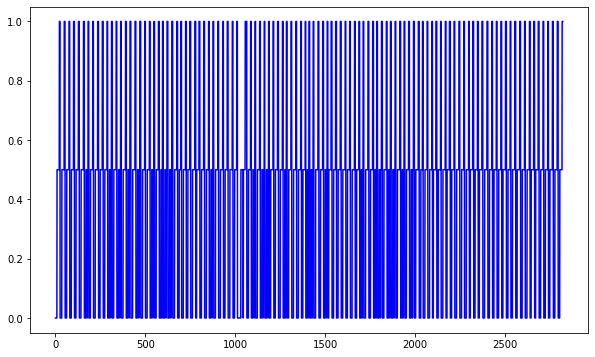

In [41]:
plt.figure(figsize=(10,6))
plt.plot(new_data_scaled, color='blue', label='Actual Apple Stock Price')
plt.plot(predictions , color='red', label='Predicted Apple Stock Price')
plt.title('Apple Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Apple Stock Price')
plt.legend()
plt.show()